# DG Tutorial Part 1: the simplest possible case

**Alex Pandya**

alex.pandya@cornell.edu

### Sources:

[1] "An Introduction to Discontinuous Galerkin Methods", by Josh Bevan (https://github.com/userjjb/22_6xx-DG-for-PDEs/tree/master)

[2] "Runge-Kutta Discontinuous Galerkin Methods for Convection-Dominated Problems" by Bernardo Cockburn and Chi-Wang Shu

[3] "Finite Volume Methods for Hyperbolic Problems" by Randall J. LeVeque

## Conservation laws

This notebook is meant to serve as a simple introduction to the **discontinuous Galerkin (DG) method** for solving hyperbolic conservation laws of the form

$$
\frac{\partial}{\partial t} \mathbf{q}(\mathbf{u}) + \frac{\partial}{\partial x^i} \mathbf{f}^{i}(\mathbf{u}) = \mathbf{S}(\mathbf{u}).
$$

In this equation, the quantities $\mathbf{q}$ are _conserved variables_, $\mathbf{f}$ are _fluxes_, $\mathbf{S}$ are _sources_, and all of these terms are functions of a set of _primitive variables_ $\mathbf{u}$.  Bold font is used to denote the fact that all of the aforementioned terms can be vectors, allowing us to put systems of conservation laws into the form above.

## 1D scalar advection equation

In this notebook we will consider the simplest possible case of a conservation law, namely the 1D scalar advection equation

$$
\begin{equation} \tag{1}
\begin{aligned} 
\frac{\partial}{\partial t} q + \frac{\partial}{\partial x} f(q) &= 0 \\
f(q) &= c q \\
\end{aligned}
\end{equation}
$$

which has a single scalar conserved variable $q$, the flux is $\mathbf{f} = c q$ (where $c$ is a constant), there is no source term, and the conserved variable is also our primitive variable.

To avoid having to specify boundary conditions, we will consider a periodic domain with

$$
x \in [0, 1].
$$

## DG discretization

### Weak formulation of the PDE

We will begin by dividing our domain $x \in [0, 1]$ into $K$ _elements_ which we will index with $k$.  In principle, these elements can all have different sizes, but we will simplify matters by asserting they all have the same size

$$
\Delta x \equiv \frac{x_{max} - x_{min}}{K} = \frac{1}{K}.
$$

Thus each element has extent 

$$
\Omega_k \equiv \big[ x_L, ~x_R \big] = \big[ k \Delta x, ~(k+1) \Delta x \big].
$$

The DG discretization comes from the _weak formulation_ of the PDE, which is obtained by multiplying the PDE (1) by a smooth, compactly supported test function $\phi(x)$ and integrating over each of the spatial elements:

$$
\begin{equation} \tag{2}
\begin{aligned}
0 &= \int_{\Omega_k} \phi \, \frac{\partial q}{\partial t} \, dx + \int_{\Omega_k} \phi \, \frac{\partial f(q)}{\partial x} \, dx \\
&= \int_{x_L}^{x_R} \phi \, \frac{\partial q}{\partial t} \, dx + \big[ f(q) \, \phi \big]^{x_R}_{x_L} - \int_{x_L}^{x_R} f(q) \, \frac{\partial \phi}{\partial x} \, dx \\
\end{aligned}
\end{equation}
$$

where we have integrated the spatial derivative term by parts.

The _weak solution_ to the PDE (1) is defined to be a function $q$ which satisfies (2) _for all smooth, compactly supported test functions $\phi$_.

### Approximating the solution

We will now consider a vector space $V$ spanned by a complete set of basis functions $\psi_i$.  The fact that $V$ is complete implies that we can write our PDE solution $q$ as

$$
q(t,x) = \sum_{i=0}^{\infty} a_i(t) \, \psi_i \big[ \xi(x) \big],
$$

so our solution is expressed as a set of time-dependent coefficients $a_i(t)$ times the basis functions $\psi_i$, which encode the spatial dependence.  Notice that we have allowed $\psi_i$ to depend on $x$ in a nontrivial way: they depend on $\xi(x)$, where $\xi$ is an arbitrary (invertible) function.

We now produce a discrete approximation to the PDE solution via

$$
\tilde{q}(t, x) = \sum_{i=0}^{M} a_i(t) \, \psi_i \big[ \xi(x) \big],
$$

so instead of summing over all basis functions in the space $V$, we sum the first $M+1$ of them (note that we start the sum at $i=0$).

Furthermore, instead of checking all admissible test functions $\phi$, we will only test the ones that can be written in terms of those $M+1$ basis functions; a simple choice, then, is to take

$$
\phi(\xi) \equiv \psi_j(\xi)
$$

where $j$ runs from $0$ to $M$.

### Deriving the discrete approximation to the PDE

Inserting the approximate solution $\tilde{q}$ in for $q$ and the basis functions $\psi_j$ in for $\phi$ in (2) yields

$$
\begin{equation}
\begin{aligned}
0 &= \int_{x_L}^{x_R} \psi_j \, \frac{\partial \tilde{q}}{\partial t} \, dx + \big[ f(\tilde{q}) \, \psi_j \big]^{x_R}_{x_L} - \int_{x_L}^{x_R} f(\tilde{q}) \, \frac{\partial \psi_j}{\partial x} \, dx \\
&= \sum_{i=0}^{M} \frac{\partial a_i}{\partial t} \int_{x_L}^{x_R} \psi_i \, \psi_j \, dx + \big[ f(\tilde{q}) \, \psi_j \big]^{x_R}_{x_L} - c \sum_{i=0}^{M} a_i \int_{x_L}^{x_R} \psi_i \, \frac{\partial \psi_j}{\partial x} \, dx \\
&= \sum_{i=0}^{M} \frac{\partial a_i}{\partial t} M_{ij} + F_j - c \sum_{i=0}^{M} a_i K_{ij} \\
&= \frac{\partial \mathbf{a}}{\partial t} \cdot \mathbf{M} + \mathbf{F} - c \, \mathbf{a} \cdot \mathbf{K}, \\
\end{aligned}
\end{equation}
$$

which we can solve for the time derivative of the coefficient vector $\mathbf{a}$:

$$
\begin{equation} \tag{3}
\frac{\partial \mathbf{a}}{\partial t} = \mathbf{M}^{-1} \cdot \Big( c \, \mathbf{a} \cdot \mathbf{K} - \mathbf{F} \Big),
\end{equation}
$$

where we have defined the _mass matrix_

$$
\begin{aligned}
M_{ij} &\equiv \int_{x_L}^{x_R} \psi_i\big[ \xi(x) \big] \, \psi_j \big[ \xi(x) \big] \, dx \\
&= \int_{\xi(x_L)}^{\xi(x_R)} \psi_i(\xi) \, \psi_j(\xi) \, J \, d\xi \\
\end{aligned}
$$
where $J \equiv \frac{\partial x}{\partial \xi}$ is the jacobian of the coordinate transformation from $x$ to $\xi$.  Similarly, the _stiffness matrix_ is
$$
\begin{aligned}
K_{ij} &\equiv \int_{x_L}^{x_R} \psi_i\big[ \xi(x) \big] \, \frac{\partial \psi_j\big[ \xi(x) \big]}{\partial x} \, dx \\
&= \int_{\xi(x_L)}^{\xi(x_R)} \psi_i(\xi) \, \frac{\partial \psi_j(\xi)}{\partial \xi} \frac{\partial \xi}{\partial x} \, \frac{\partial x}{\partial \xi} \, d\xi \\
&= \int_{\xi(x_L)}^{\xi(x_R)} \psi_i(\xi) \, \frac{\partial \psi_j(\xi)}{\partial \xi} \, d\xi \\
\end{aligned}
$$
where the factor of the jacobian has cancelled with the factor of the inverse jacobian brought in by the spatial derivative term. Finally the flux term is

$$
\begin{aligned}
F_{j}  &\equiv \big[ f(\tilde{q}) \, \psi_j \big]^{x_R}_{x_L} \\
&\to \big[ \hat{f} \, \psi_j \big]^{x_R}_{x_L} \\
&= \hat{f}(x_R) \psi_j(x_R) - \hat{f}(x_L) \psi_j(x_L) \\
\end{aligned}
$$

where $\hat{f}$ is a numerical flux function, which is defined so that our numerical scheme is able to capture discontinuous (shock) solutions.  

### Numerical flux

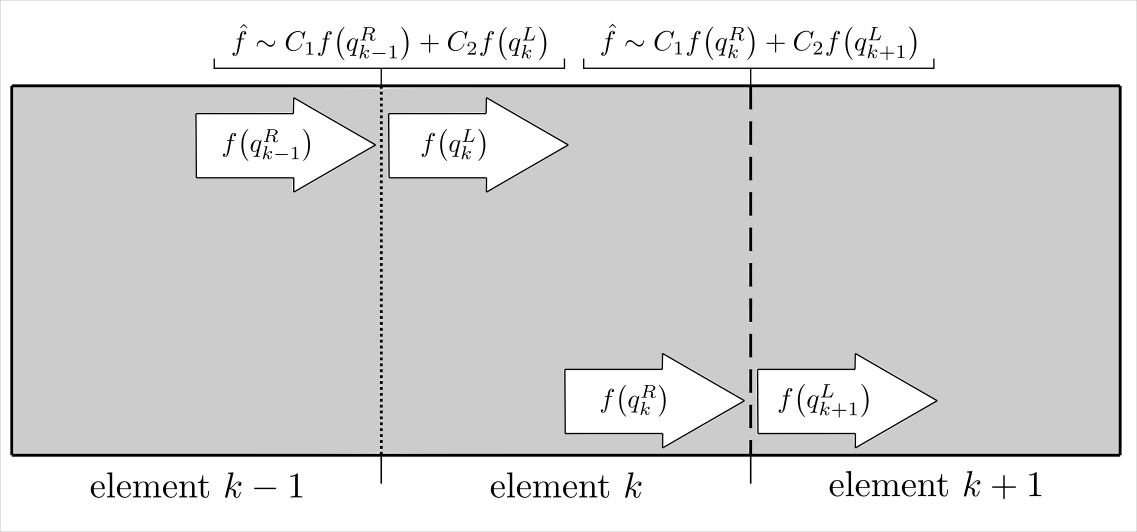

The flux determines the amount of the conserved quantity $q$ that flows between elements.  In the figure above, we have drawn an element labeled $k$ along with its two neighbors $k-1, k+1$.

In order to solve the discrete evolution equation in cell $k$, we'll need to know the flux at both the left interface (dotted line) and the right one (dashed line).  Let's begin with the left (dotted) interface.  We can see that we have two approximate values of the flux at that point, namely the one from the right side of cell $k-1$, and the one from the left side of cell $k$ (shown in the upper pair of arrows).

The job of the _numerical flux function_ is to choose between these two fluxes in a way that gives a solution that (1) is stable and (2) captures discontinuities in the solution. The numerical flux $\hat{f}$ (drawn above the interface) is usually a linear combination of the flux from the elements on each side of the interface (though the coefficients can be complicated functions of the solution, i.e. may depend on the PDE's characteristics).  

As long as our scheme asserts that the flux flowing out of an element is equal to that flowing into the next element (that is, we use the same $\hat{f}$ as the flux out of element $k-1$ and into element $k$, for example) the numerical scheme is said to be _conservative_.  Conservative schemes preserve the total amount of $q$ across the domain as long as there are no sources or boundaries for it to flow in/out of.

#### Upwind flux function

In this notebook we are focused on solving the 1D scalar advection equation with speed $c$.  We will restrict to the case where $c > 0$, which implies that the flow of $q$ is always to the right.

With this knowledge in mind, we will employ the _upwind flux function_, which in this case just picks $\hat{f}$ to be the flux on the left side of the interface:
$$
\hat{f}_{k}(x_L) = c \tilde{q}_{k-1}(x_R), ~~~ \hat{f}_{k}(x_R) = c \tilde{q}_{k}(x_R).
$$

## Building the solver

Now that we've derived the semidiscrete solution scheme, (3), we will choose a set of basis functions $\phi_j$ and we will build a simple DG solver for the 1D scalar advection equation.

Below we begin by importing a few useful libraries and functions; we also set matplotlib parameters to make the plots look a bit better.

In [2]:
#define imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import quad
from numpy.linalg import inv
import ipywidgets as widgets

# Set plot parameters (credit: Mani Chandra)
pl.rcParams['figure.figsize']  = 5, 3
pl.rcParams['lines.linewidth'] = 2
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'
pl.rcParams['figure.dpi']      = 300

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'

### Set the wave speed

The scalar advection equation has one parameter, namely the wave speed $c$.  For the sake of simplicitly, we have assumed $c > 0$, and we set its value below.

In [3]:
#define wave speed c
c = 1.

### Fixing the basis functions

Now we will fix the basis functions.

For the sake of simplicity, we will consider the basis of monomials ($\psi_j \sim \xi^j$) and we will only consider the first two basis functions, so $M = 1$.  We will write these basis functions as
$$
\psi_0(\xi) = 1 - \xi, ~~~ \psi_1(\xi) = \xi,
$$
where $\xi \in [0,1]$.

The map from the coordinate $\xi$ to $x$ is given by
$$
x(\xi) = x_L + \xi(x_R - x_L) = k \, \Delta x + \xi \, \Delta x,
$$
which implies the jacobian is
$$
J \equiv \frac{\partial x}{\partial \xi} = \Delta x.
$$

In [4]:
#define basis functions
def psi0(xi):
    return 1-xi

def psi1(xi):
    return xi

#define analytic derivatives of basis functions
def psi0P(xi):
    return -1

def psi1P(xi):
    return 1

#define dx
def dx(N):
    xMax = 1.
    xMin = 0.
    
    return (xMax-xMin)/N

#define Jacobian
def J(N):
    return dx(N)

#define x(k, xi), where k is the index of the cell
def x(k, xi, N):
    return k*dx(N) + xi*dx(N)

## Computing the terms in (3)

Given the grid, coordinate map $x(\xi)$, the jacobian, the basis functions $\psi_j$, and their derivatives, we can compute the mass and stiffness matrices.  

Starting with the mass matrix, we find:

$$
\begin{aligned}
M_{ij} &= \int_{\xi(x_L)}^{\xi(x_R)} \psi_i(\xi) \, \psi_j(\xi) \, J \, d\xi \\
&= \Delta x \int_0^1 \psi_i(\xi) \psi_j(\xi) \, d\xi \\
\implies \mathbf{M} &= \frac{\Delta x}{6}
\begin{pmatrix}
2 & 1 \\
1 & 2
\end{pmatrix}.
\end{aligned}
$$

Doing the same for the stiffness matrix gives us
$$
\begin{aligned}
K_{ij} &= \int_{\xi(x_L)}^{\xi(x_R)} \psi_i(\xi) \, \frac{\partial \psi_j(\xi)}{\partial \xi} \, dx \\
&= \int_0^1 \psi_i(\xi) \, \frac{\partial \psi_j(\xi)}{\partial \xi} \, d\xi \\
\implies \mathbf{K} &= \frac{1}{2}
\begin{pmatrix}
-1 & -1 \\
1 & 1
\end{pmatrix}
\end{aligned}.
$$

Finally the flux term is

$$
\begin{aligned}
F_j &= \hat{f}(x_R) \psi_j(x_R) - \hat{f}(x_L) \psi_j(x_L) \\
&= c \tilde{q}_k(x_R) \psi_j(x_R) - c \tilde{q}_{k-1}(x_R) \psi_j(x_L) \\
&= c \tilde{q}_k(x_R) \delta_{j,1} - c \tilde{q}_{k-1}(x_R) \delta_{j,0} \\
\implies \mathbf{F} &= 
\begin{pmatrix}
-c \tilde{q}_{k-1}(x_R) \\
c \tilde{q}_{k}(x_R)
\end{pmatrix},
\end{aligned}
$$
where we have used the fact that $\psi_0(x_R) = \psi_1(x_L) = 0$ and $\psi_0(x_L) = \psi_1(x_R) = 1$ to arrive at the third line.

Below we define python functions to compute the mass/stiffness matrices and the flux term.

In [5]:
#define mass matrix; since the mass matrix is just a constant, this function
#only needs to be called once and the result should be stored for the evolution
def Mij(N):
    M00 = quad(lambda xi: J(N)*psi0(xi)*psi0(xi), 0, 1)[0]
    M01 = quad(lambda xi: J(N)*psi0(xi)*psi1(xi), 0, 1)[0]
    M10 = M01
    M11 = quad(lambda xi: J(N)*psi1(xi)*psi1(xi), 0, 1)[0]
    return [[M00, M01],[M10, M11]]

#define stiffness matrix; again, it is constant, so we only need to evaluate this
#function once and the result should be stored for the evolution
def Kij():
    K00 = quad(lambda xi: psi0P(xi)*psi0(xi), 0, 1)[0]
    K01 = quad(lambda xi: psi0P(xi)*psi1(xi), 0, 1)[0]
    K10 = quad(lambda xi: psi1P(xi)*psi0(xi), 0, 1)[0]
    K11 = quad(lambda xi: psi1P(xi)*psi1(xi), 0, 1)[0]
    return [[K00, K01],[K10, K11]]

#define q tilde, the approximate solution; this is a function of the cell index
#k, xi, and the vector of weights a_n; a_n[k] = (a_0, a_1) for element k
def qt(k, xi, a):
    return ( a[k, 0]*psi0(xi) + a[k, 1]*psi1(xi))

#define flux (boundary) term; this is a function of position, so take in a cell
#index k as an argument and the solution vector a_n
def f(k, a_n):
    f0 = -c*qt(k-1, 1, a_n)
    f1 = c*qt(k, 1, a_n)
    return [f0, f1]

Let's check that the matrices give us what we expect, since we computed them analytically above and they're just constant matrices.

In [6]:
#set N = Ntemp (chosen arbitrarily) to check that the
#mass matrix is being computed correctly
Ntemp = 25

expectedMassMatrix = dx(Ntemp)/6. * np.array([[2, 1],[1, 2]])
print('expected mass matrix:')
print(np.array(expectedMassMatrix))
print()
print('computed mass matrix:')
print(np.matrix(Mij(Ntemp)))
print('\n')

expectedStiffnessMatrix = 0.5*np.array([[-1, -1],[1, 1]])
print('expected stiffness matrix:')
print(np.array(expectedStiffnessMatrix))
print()
print('computed stiffness matrix:')
print(np.matrix(Kij()))

expected mass matrix:
[[0.01333333 0.00666667]
 [0.00666667 0.01333333]]

computed mass matrix:
[[0.01333333 0.00666667]
 [0.00666667 0.01333333]]


expected stiffness matrix:
[[-0.5 -0.5]
 [ 0.5  0.5]]

computed stiffness matrix:
[[-0.5 -0.5]
 [ 0.5  0.5]]


## Build the rest of the solver

### Computing the right-hand side

Recall that we want to solve (3),

$$
\begin{equation} \tag{3}
\frac{\partial \mathbf{a}}{\partial t} = \mathbf{M}^{-1} \cdot \Big( c \, \mathbf{a} \cdot \mathbf{K} - \mathbf{F} \Big),
\end{equation}
$$

We now have all of the ingredients to construct the right-hand side of (3), which we do in the cell below.

In [146]:
#define the right-hand side function; this takes as arguments
#the cell index k, a coefficient vector at timestep n called a_n,
#the inverse of the mass matrix Minv, and the stiffness matrix K
def RHS(k, a_n, Minv, K):   
    return np.dot(Minv, c*np.dot(K, a_n[k])-f(k,a_n))

### Timestepper

Now we have to address the left-hand side of (3).  To keep the solver _as simple as possible_, we'll use the forward Euler method.  In the cell below, we define a function called `step()` which takes one timestep and returns $a_i$ at the timestep $n+1$, and a function that repeatedly calls `step()` to evolve the system `TS` timesteps.

In [147]:
#define step() function which returns a_np1 given a_n
def step(a_n, a_np1, Minv, K, dt):
    #for each element compute a at the next time level
    for k in range(N):
        a_np1[k] = a_n[k] + dt*RHS(k, a_n, Minv, K)

    return a_np1

#evolve system TS timesteps; takes in # of timesteps TS,
#coefficient vector at initial time a_n, and empty
#coefficient vector at advanced time a_np1
def evolve_TS_steps(TS, a_n, dt):
    #compute mass matrix, stiffness matrix, inverse of
    #mass matrix; do this just once per evolution,
    #since these are all constant matrices
    K    = Kij()
    M    = Mij(N)
    Minv = inv(M)

    #save all data to an array called sol, starting with ID
    sol = a_n
    
    #define temporary matrix to store coefficient matrix
    #at advanced time level
    a_np1 = np.ones(np.shape(a_n))
    
    for n in range(TS):
        a_np1 = step(a_n, a_np1, Minv, K, dt)
        #append a_np1 to sol
        sol = np.append(sol, a_np1)
        #copy a_np1 into a_n for next timestep
        a_n = a_np1

    #reshape sol to be (TS, N, 2), so sol[n] = a_n 
    #at time level n
    return np.reshape(sol, (TS+1, N, 2))

### Setting initial data

Now we need to set the initial data.  We will do this by specifying $q(t=0, x)$ through the function `q_ID()`, which we will then project onto the function space $V = \{\psi_0, \psi_1\}$ using the function `compute_ID_a()`.

In [148]:
#define initial data.  Notice that for cell k, a_{0,k} = q(x_L)
#and a_{1,k} = q(x_R)
def q_ID(x):
    mu = 0.5
    sigma = 0.05
    return np.exp(-(x-mu)**2./sigma**2.)

#compute the coefficients a_n[k] corresponding to projecting analytic ID
#from q_ID(x) onto the basis (psi_0, psi_1)
def compute_ID_a(N):
    #define a_n = solution vector at time level n; should have shape (N, 2), where
    #N is the number of elements (i.e. we have a_0, a_1 for each element)
    a_n = np.ones((N,2))

    #index cells from k = 0 to N; cell boundary is at 
    #(k*dx, [k+1]*dx); define array of boundaries cbound
    cbound = [k*dx(N) for k in range(N+1)]
    
    for k in range(N):
        a_n[k,0] = q_ID(cbound[k])
        a_n[k,1] = q_ID(cbound[k+1])

    return a_n

Let's check that we've specified the initial data correctly.  Here we'll compute the coefficient vector `a_n` corresponding to the initial data, then we'll compute the corresponding solution $\tilde{q}(x)$ and plot it alongside the analytic initial data from the `q_ID()` function.  

To expedite this process, we define a helper function `plot_soln()` to make plots.

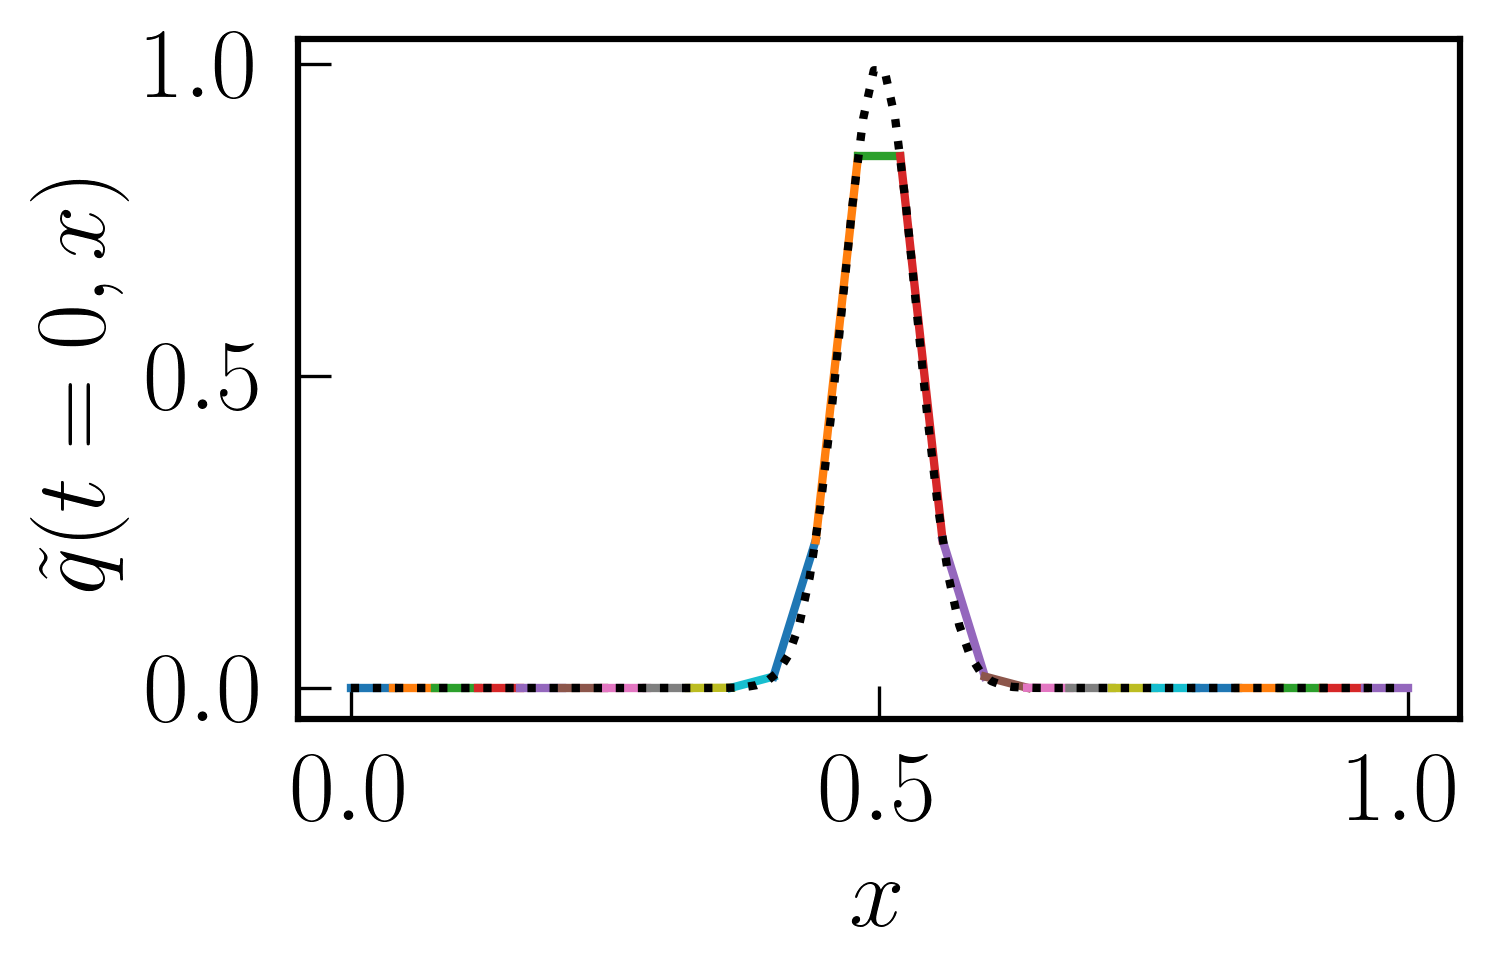

In [149]:
#plot solution given coefficient vector a_n; takes an optional matplotlib
#style string
def plot_soln(a_n, N, styleString=''):
    #xi in each element
    xi = np.linspace(0., 1, 10)

    #plot approximate solution qtilde(x)
    for k in range(N):
        pl.plot(x(k,xi,N), qt(k, xi, a_n), styleString)

#compute initial data for Ntemp elements
Ntemp = 25
a_n = compute_ID_a(Ntemp)

#plot initial data as a black dotted line
plot_soln(a_n, Ntemp)

#plot exact initial data
xx = np.linspace(0, 1, 100)
pl.plot(xx, q_ID(xx), 'k:')
pl.xlabel('$x$')
pl.ylabel('$\\tilde{q}(t=0, x)$')
pl.show()

## Evolve the system

Now that the solver is built and the initial data is specified, we can run the solver for `TS` timesteps and get out the final result.  This is done in the cell below.

In [150]:
#define the timestep size given the CFL number
#and the spatial grid spacing dx
def dt(CFL, N):
    return CFL*dx(N)

#define a wrapper function to set ID and solve system
#all at once
def solve_system(t_end, CFL, N):
    #compute number of timesteps, TS
    TS = int(t_end/dt(CFL, N)) + 1
    
    #compute ID and define coefficient matrix at t=0
    a_n = compute_ID_a(N)
    
    return evolve_TS_steps(TS, a_n, dt(CFL, N))

In [160]:
#compute solution after TS timesteps
t_end = 1
CFL   = 0.01
N     = 24

sol = solve_system(t_end, CFL, N)

### Plot solution alongside analytic solution

The 1D scalar advection equation has a well-known analytic solution; given initial data $f(x)$, the solution at a later time $t$ is given by $f(x - ct)$; in other words, the initial data is _advected_ at velocity $c$.

Below we define a function called `q_analytic()` which computes the analytic solution, accounting for the fact that we have periodic boundary conditions.

In [161]:
#define analytic solution, which is just q_ID(x-c*t)
def q_analytic(t, x):
    #mod 1 to account for periodic boundary conditions
    u = (x-c*t)%1
    return q_ID(u)

Below we define a function to plot the solution from the solver (colored lines) along with the analytic solution (black dotted line).  A slider controls the timestep at which the solution is shown.

In [162]:
#make plot live-update with slider; if this is too slow,
#comment out the @widgets.interact line and uncomment
#the widgets.interact_manual one below it; that one only
#draws the plot when you hit "Run Interact"; see
#https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/
@widgets.interact(timestep=(0, np.shape(sol)[0]-1))
#@widgets.interact_manual(timestep=(0, TS))

def plot_slider(timestep=0):
    
    #plot numerical solution   
    coeffMatrix = sol[timestep]
    #define N = number of elements
    N = np.shape(sol)[1]
    plot_soln(coeffMatrix, N)
    
    #plot analytic solution
    xx = np.linspace(0, 1, 100)
    pl.plot(xx, q_analytic(timestep*dt(CFL, N), xx), 'k:')
    
    #decorate plot
    pl.xlabel('$x$')
    pl.ylabel('$\\tilde{q}(t,x)$')
    pl.ylim([-0.05, 1.05])

interactive(children=(IntSlider(value=0, description='timestep', max=2401), Output()), _dom_classes=('widget-i…

Feel free to play with the parameters `t_end`, `CFL`, and `N` to see how they impact the solution.